#### Solar irradiance is a measure of how much energy the sun sends to the Earth. Imagine that the sun is like a big light bulb in the sky, and it sends out light and heat to the Earth. The amount of light and heat that the sun sends to the Earth is called solar irradiance. We use special tools to measure how much solar irradiance there is at different places on the Earth. Solar irradiance is important because it helps us to understand how much energy we can get from the sun. Example of how solar irradiance can be used:

#### Imagine that you are planning to install solar panels on the roof of your house. You want to make sure that you will get enough energy from the sun to power your house. To do this, you can use solar irradiance data to help you predict how much energy the solar panels will be able to produce.

#### The dataset used in this project is meteorological data from the HI-SEAS weather station from four months (September through December 2016) between Mission IV and Mission V.

#### For each dataset, the fields are:

#### A row number (1-n) useful in sorting this export's results The UNIX time_t date (seconds since Jan 1, 1970). Useful in sorting this export's results with other export's results the date in yyyy-mm-dd format the local time of day in hh:mm:ss 24-hour format The numeric data, if any (may be an empty string) The text data, if any (may be an empty string). Using this data, we will extract features and using those features we can predict the radiations.

#### The units of each dataset are:

Solar radiation: watts per meter^2
Temperature: degrees Fahrenheit
Humidity: percent
Barometric pressure: Hg
Wind direction: degrees
Wind speed: miles per hour
Sunrise/sunset: Hawaii time


# Table of Content
#### 1.Importing Libraries
#### 2.Loading Data
#### 3.Data Wrangling
#### 4.Feature Selection using Correlation Matrix
#### 5.Feature Selection using SelectKBest Method
#### 6.Feature Selection using Extra Tree Classifier
#### 7.Feature Engineering with BoxCox, Log, Min-Max and Standard transformation
#### 8.Preparing data - Standardisation and Splitting
#### 9.Prediction with XGBoost
#### 10.Using MultiLayer Perceptron for prediction

# 1. Importing the libraries

In [4]:
!pip install xgboost

In [5]:
!pip install tensorflow

In [6]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split

# !pip install xgboost
import xgboost as xgb

from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from collections import Counter

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 2. Loading Data

In [8]:
data = pd.read_csv('SolarPrediction.csv')

In [9]:
data.head(5)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


# 3.Data Wrangling

In [12]:
df = data.copy()

In [13]:
# extract the data from the date_time format of the 'Data' parameter
df['Data'] = df['Data'].apply(lambda x : x.split()[0])

In [14]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [15]:
# extract the date time features from the given parameter using data time python methods
df['Month'] = pd.to_datetime(df['Data']).dt.month
df['Day'] = pd.to_datetime(df['Data']).dt.day
df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df['Minute'] = pd.to_datetime(df['Time']).dt.minute
df['Second'] = pd.to_datetime(df['Time']).dt.second

In [16]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24


In [17]:

# extract the sunrise and sunset information using regular expression
df['risehour'] = df['TimeSunRise'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['riseminuter'] = df['TimeSunRise'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

df['sethour'] = df['TimeSunSet'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['setminute'] = df['TimeSunSet'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)


In [18]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26,6,13,18,13
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23,6,13,18,13
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26,6,13,18,13
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21,6,13,18,13
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24,6,13,18,13


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
 11  Month                   32686 non-null  int32  
 12  Day                     32686 non-null  int32  
 13  Hour                    32686 non-null  int32  
 14  Minute                  32686 non-null

In [20]:
# drop the parameters that are not requires after extracting the relevant information
df.drop(['UNIXTime','Data','Time','TimeSunRise','TimeSunSet'], axis = 1, inplace = True)

In [21]:
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,1.21,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,1.17,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


In [22]:
# check of data dimension
df.shape

(32686, 15)

In [23]:
# checking for null values in the data
df.isnull().sum().sum()

0

In [24]:
# glimpse of the final data
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,1.21,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,1.17,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


In [25]:
np.array(df['Radiation'])

array([1.21, 1.21, 1.23, ..., 1.2 , 1.23, 1.2 ])

In [26]:
input_features = df.drop('Radiation', axis = 1)
target = df['Radiation']

# Feature Selection using Correlation Matrix

In [28]:
# extract the correlation between the data features
corr_matrix = df.corr()
corr_matrix

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
Radiation,1.000000,0.734955,0.119016,-0.226171,-0.230324,0.073627,-0.095450,0.039978,0.004398,-0.000730,-0.031270,NaN,-0.092850,0.048719,-0.039816
Temperature,0.734955,1.000000,0.311173,-0.285055,-0.259421,-0.031458,-0.354560,-0.123705,0.197464,-0.001934,-0.036147,NaN,-0.380968,0.300920,-0.242881
Pressure,0.119016,0.311173,1.000000,-0.223973,-0.229010,-0.083639,-0.341759,-0.024633,0.091069,0.001860,-0.031102,NaN,-0.380399,0.151939,-0.119599
Humidity,-0.226171,-0.285055,-0.223973,1.000000,-0.001833,-0.211624,-0.068854,0.014637,0.077899,0.000499,-0.027682,NaN,-0.023955,0.145143,-0.119526
WindDirection(Degrees),-0.230324,-0.259421,-0.229010,-0.001833,1.000000,0.073092,0.181485,-0.082354,-0.077969,-0.000602,-0.032568,NaN,0.176929,-0.078540,0.070030
Speed,0.073627,-0.031458,-0.083639,-0.211624,0.073092,1.000000,0.150822,0.117337,-0.057939,0.000192,-0.032934,NaN,0.167075,-0.159384,0.119926
Month,-0.095450,-0.354560,-0.341759,-0.068854,0.181485,0.150822,1.000000,0.038027,-0.005396,0.000168,0.220563,NaN,0.952472,-0.784783,0.541883
Day,0.039978,-0.123705,-0.024633,0.014637,-0.082354,0.117337,0.038027,1.000000,-0.008010,-0.000196,0.089078,NaN,0.274522,-0.263575,0.265662
Hour,0.004398,0.197464,0.091069,0.077899,-0.077969,-0.057939,-0.005396,-0.008010,1.000000,-0.004052,0.004199,NaN,-0.006772,0.008629,-0.007056
Minute,-0.000730,-0.001934,0.001860,0.000499,-0.000602,0.000192,0.000168,-0.000196,-0.004052,1.000000,0.002517,NaN,-0.000158,0.001052,-0.002215


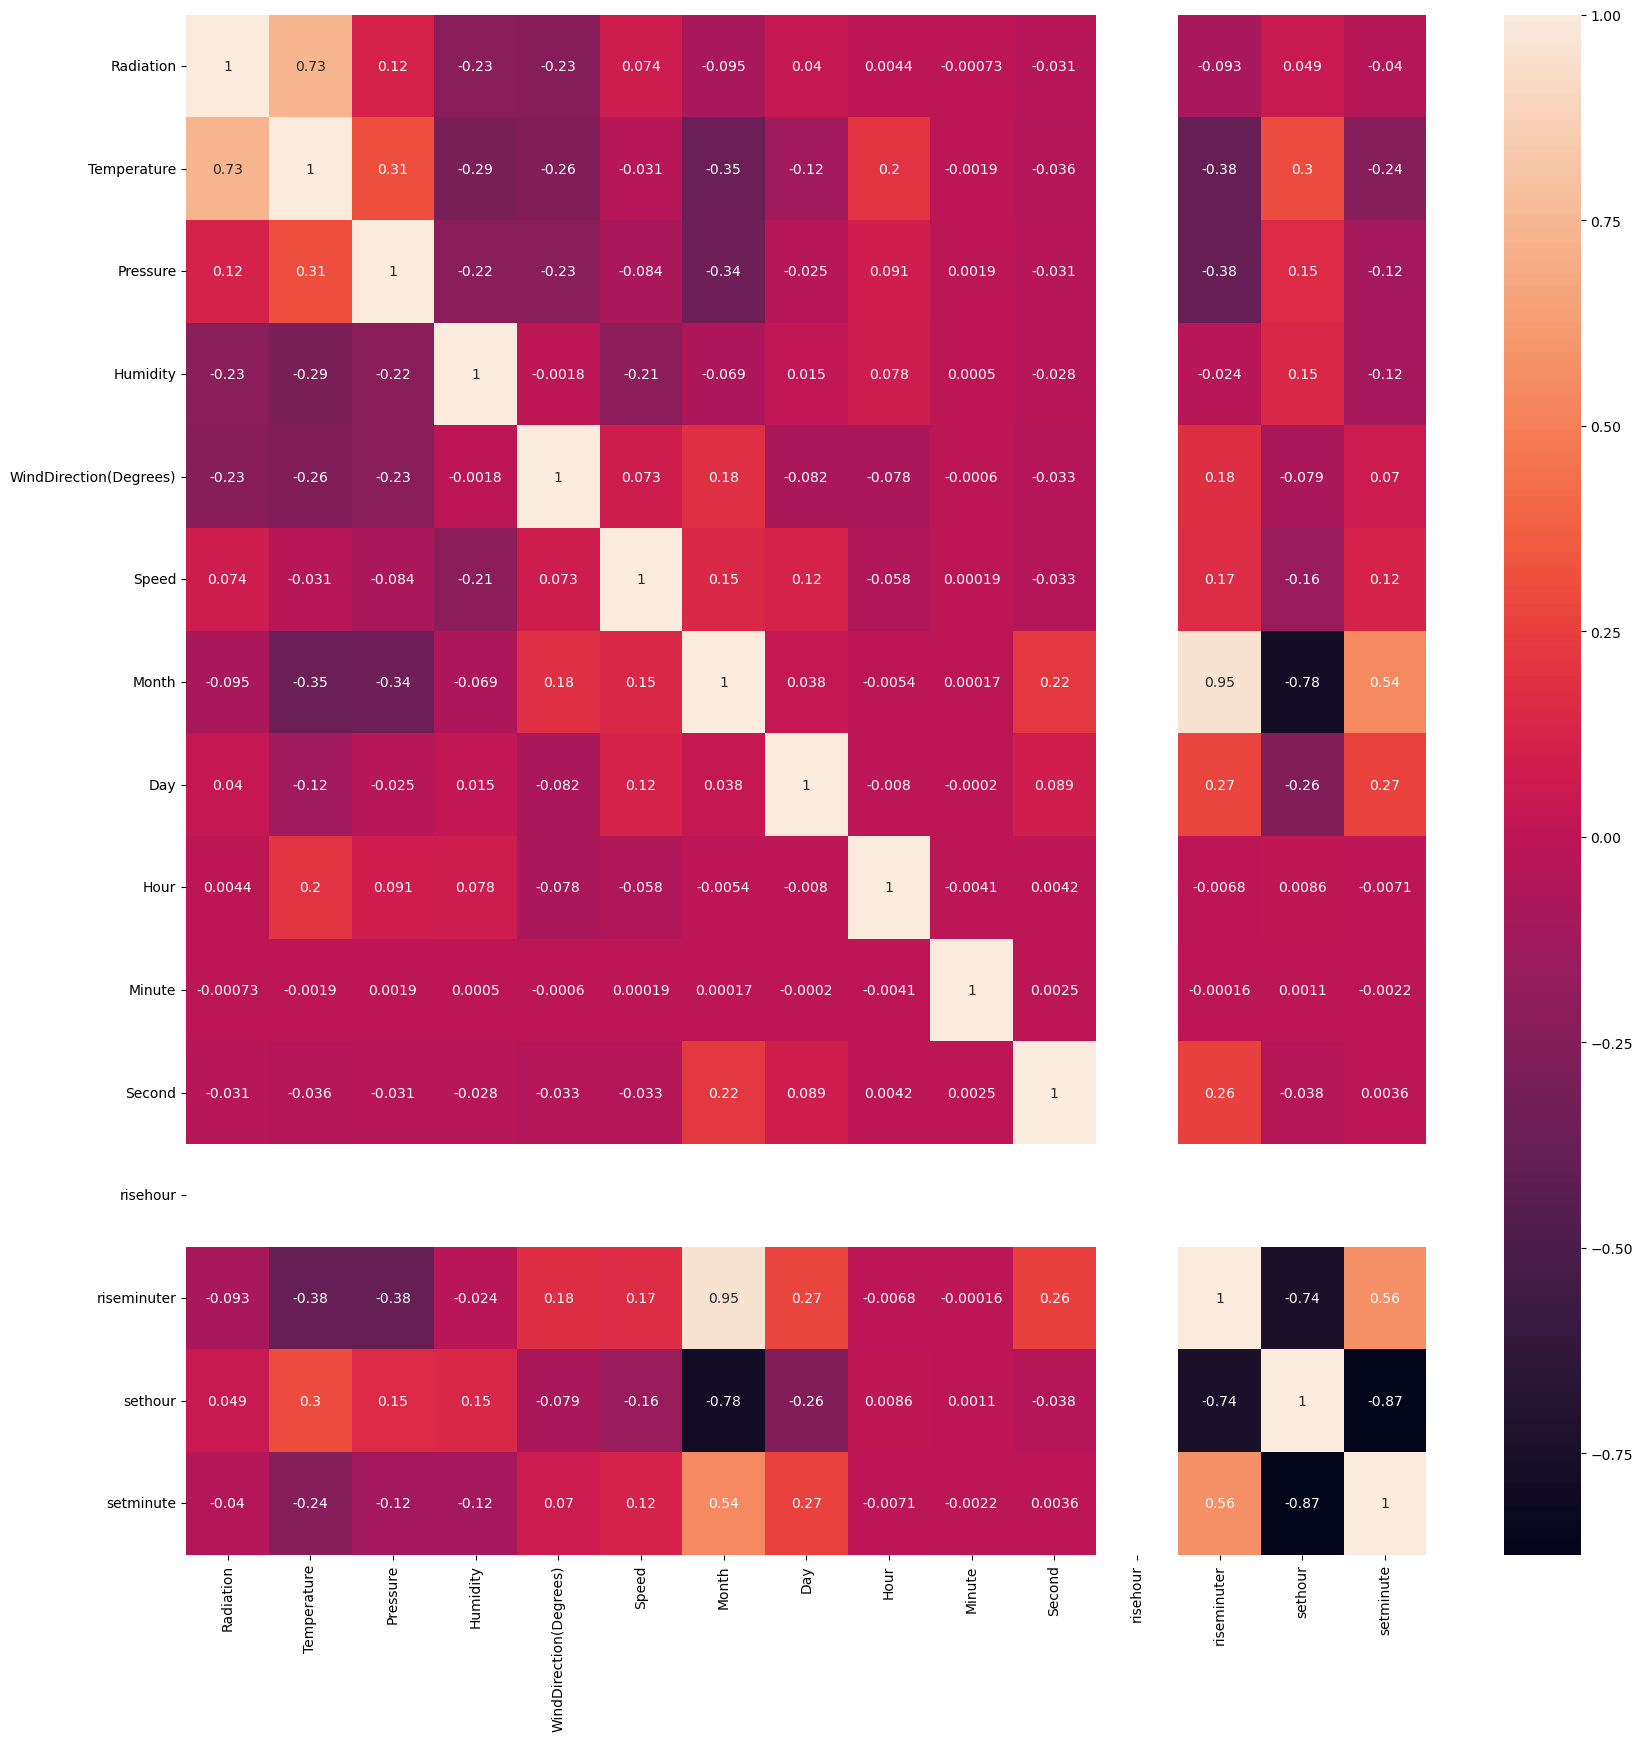

In [29]:
# plot the correlation matrix using heatmap for clear understanding
plt.figure(figsize = (20,20))
sns.heatmap(df.corr(), annot = True)
plt.show()

# Feature Selection using SelectKBest Method

In [31]:
bestfeatures = SelectKBest(score_func = chi2, k = 10)

#### it works on the target label but instead we are passing continous float values to it. So, we need to convert our data to label form and there are two methods as follows:
#### using LabelEncoder
#### multiplying the data by 100 and converting it int which can be treated as labels by the model 

In [33]:
# use the label encoder
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder()
train_Y = label_encoder.fit_transform(target)

In [34]:
target_cont = df['Radiation'].apply(lambda x: int(x*100))
scaled_input_features = MinMaxScaler().fit_transform(input_features)
fit = bestfeatures.fit(scaled_input_features, target_cont)

In [35]:
scores = pd.DataFrame(fit.scores_)
column = pd.DataFrame(input_features.columns)

In [43]:
# containing data_features with the scores
featureScore = pd.concat([column, scores], axis = 1)

#naing the dataframe columns
featureScore.columns = ['Features', 'feature_imp']

In [45]:
# best features
featureScore.sort_values(by = 'feature_imp', ascending = False, inplace = True)
featureScore

,Features,feature_imp
12,sethour,12207.531454
5,Month,4684.579610
11,riseminuter,4015.062771
3,WindDirection(Degrees),3271.827277
6,Day,2841.926850
8,Minute,2702.449333
9,Second,2288.673032
13,setminute,1863.712087
0,Temperature,1651.685632
2,Humidity,1588.087433


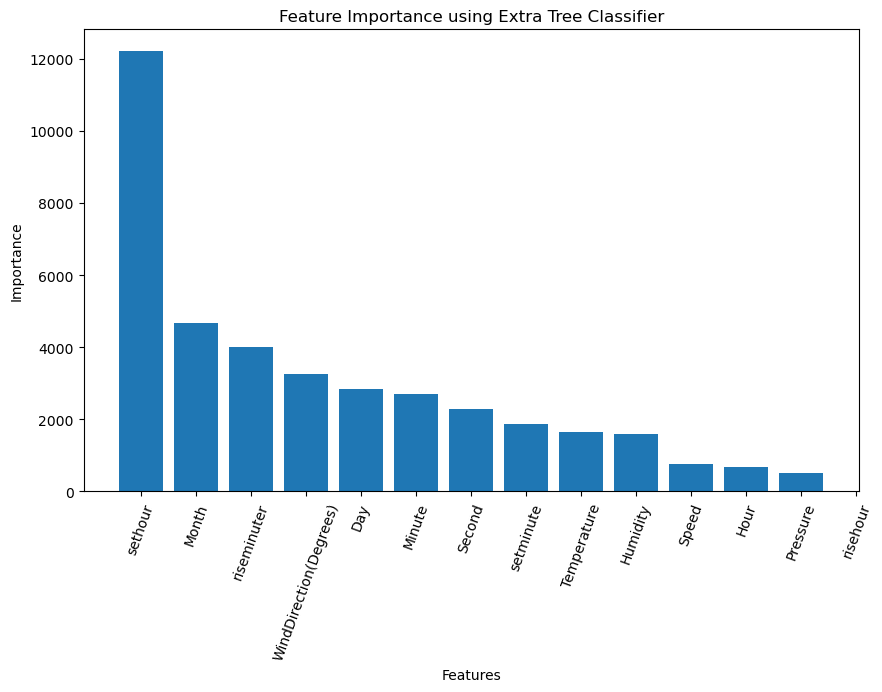

In [51]:
# Visualise the feature importance 
plt.figure(figsize = (10,6))
plt.bar(featureScore.Features, featureScore.feature_imp)
plt.xticks(rotation = 70)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance using Extra Tree Classifier')
plt.show()

# Feature Selection using Extra Tree Classifier

In [53]:
model = ExtraTreesClassifier(verbose = 1, n_estimators = 5)
model.fit(scaled_input_features, target_cont)

ExtraTreesClassifier(n_estimators=5, verbose=1)

In [55]:
feature_importances = pd.DataFrame(model.feature_importances_, index = input_features.columns, columns = ['feature_imp'])
feature_importances.sort_values(by = 'feature_imp', ascending = False, inplace = True)
feature_importances

,feature_imp
WindDirection(Degrees),0.158665
Minute,0.147676
Speed,0.123733
Second,0.123705
Humidity,0.110024
Hour,0.090146
Temperature,0.081120
Pressure,0.075109
Day,0.036371
setminute,0.025481


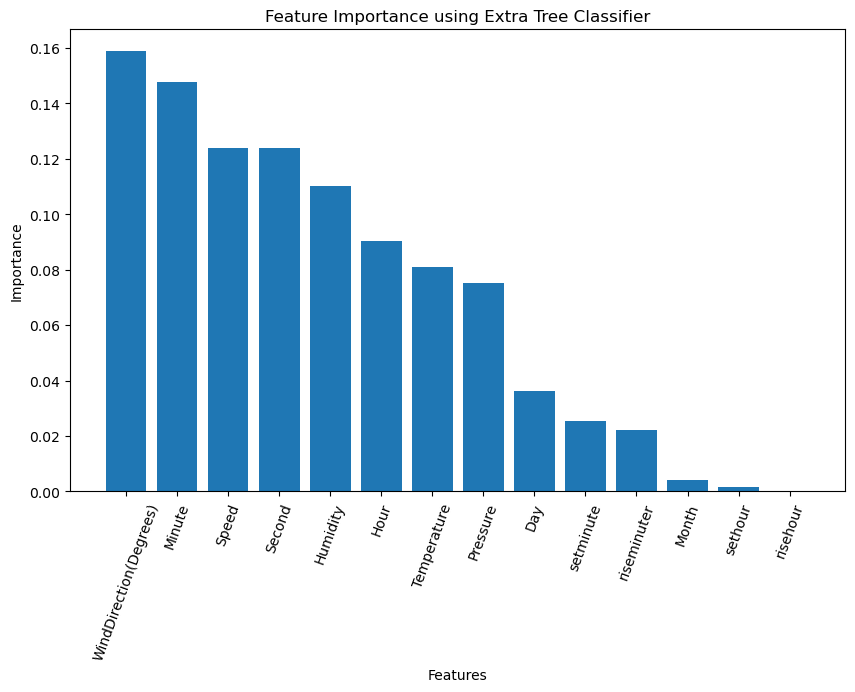

In [57]:
plt.figure(figsize = (10,6))
plt.bar(feature_importances.index, feature_importances['feature_imp'])
plt.xticks(rotation = 70)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance using Extra Tree Classifier')
plt.show()

# Feature Engineering with BoxCox, Log, Min-Max and Standard transformation

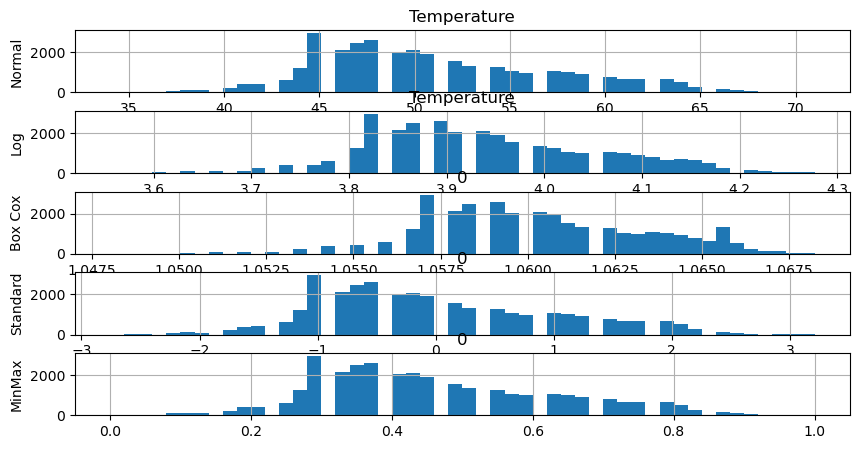

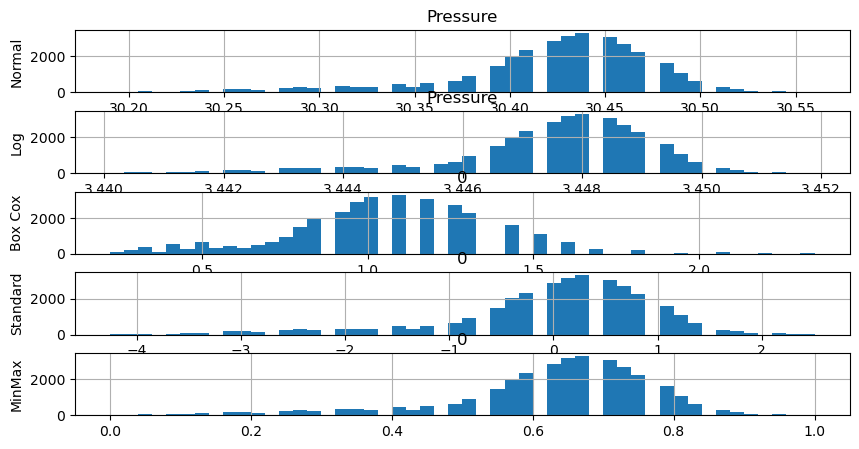

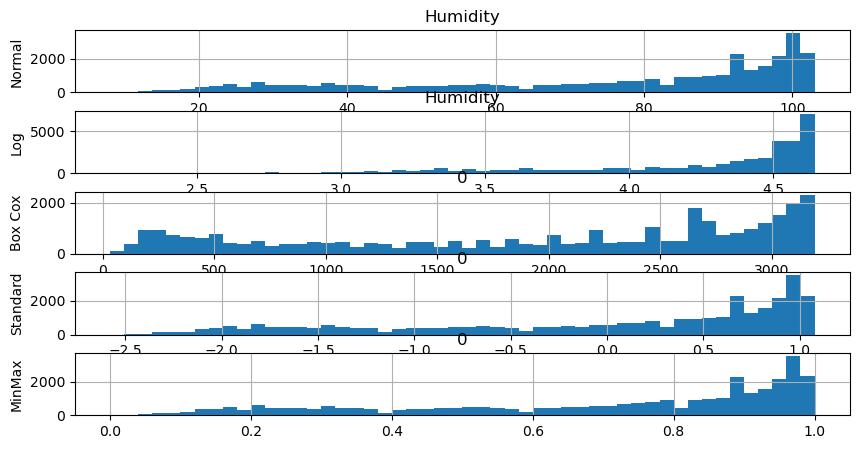

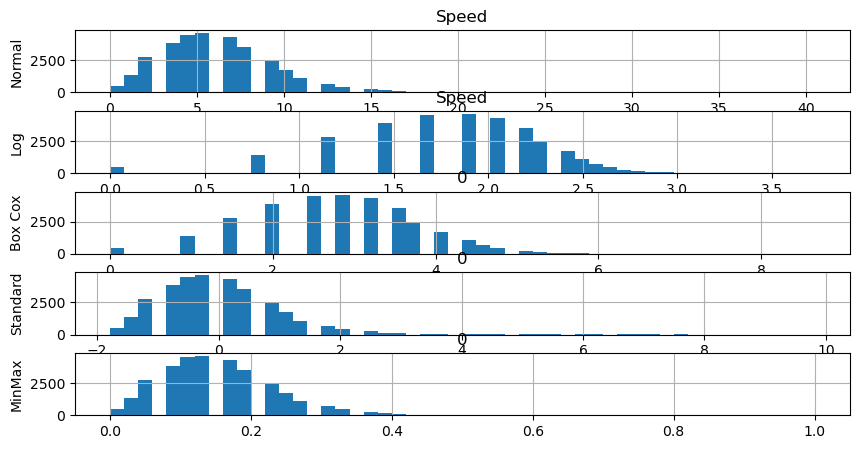

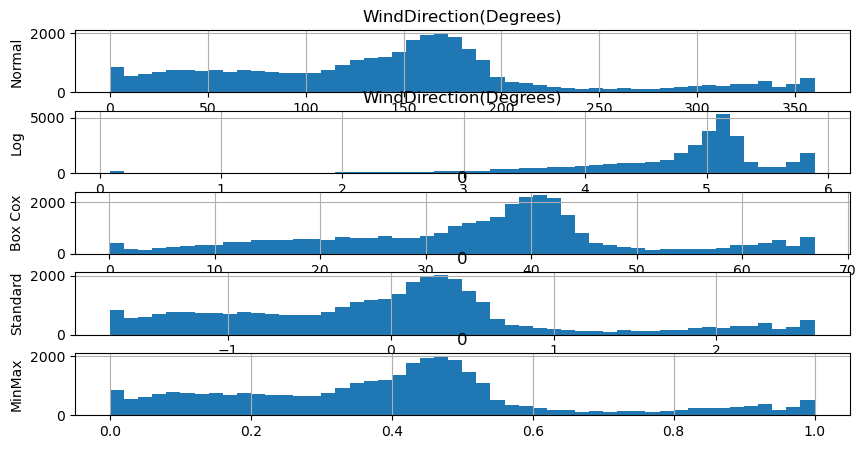

In [63]:
# Looking for transformation
features_to_transform = ['Temperature','Pressure','Humidity','Speed','WindDirection(Degrees)']

for i in features_to_transform:

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize =(10,5))

    pd.DataFrame(input_features[i]).hist(ax = ax1, bins = 50)
    pd.DataFrame((input_features[i]+1).transform(np.log)).hist(ax = ax2, bins = 50)
    pd.DataFrame(stats.boxcox(input_features[i]+1)[0]).hist(ax = ax3, bins = 50)    
    pd.DataFrame(StandardScaler().fit_transform(np.array(input_features[i]).reshape(-1, 1))).hist(ax = ax4, bins = 50)
    pd.DataFrame(MinMaxScaler().fit_transform(np.array(input_features[i]).reshape(-1, 1))).hist(ax = ax5, bins = 50)
    
    ax1.set_ylabel('Normal')
    ax2.set_ylabel('Log')
    ax3.set_ylabel('Box Cox')
    ax4.set_ylabel('Standard')
    ax5.set_ylabel('MinMax')


In [67]:
# set the transformations required
transform = {'Temperature' : (input_features['Temperature']+1).transform(np.log), 
             'Pressure': stats.boxcox(input_features['Pressure']+1)[0], 
            'Humidity' : stats.boxcox(input_features['Humidity']+1)[0], 
            'Speed' : (input_features['Speed']+1).transform(np.log), 
            'WindDirection(Degrees)' : MinMaxScaler().fit_transform(
                np.array(input_features['WindDirection(Degrees)']).reshape(-1, 1))}

for i in transform:
    input_features[i] = transform[i]

In [69]:
input_features.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,1.587564,1.246533e+297,1141.774290,0.492692,1.061290,9,29,23,55,26,6,13,18,13
1,1.587564,1.246533e+297,1106.375612,0.490996,0.906145,9,29,23,50,23,6,13,18,13
2,1.587564,1.246533e+297,1071.496849,0.440894,0.906145,9,29,23,45,26,6,13,18,13
3,1.587564,1.246533e+297,1177.691774,0.382426,0.906145,9,29,23,40,21,6,13,18,13
4,1.587564,1.246533e+297,1251.078826,0.291391,1.061290,9,29,23,35,24,6,13,18,13


# Preparing data - Standardisation and Splitting

In [72]:
xtrain, xtest, ytrain, ytest = train_test_split(input_features, target, test_size = 0.2, random_state = 1)
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [74]:
xtrain.shape, xtest.shape

((26148, 14), (6538, 14))

# XGBoost

#### What is XGBoost? 
##### XGBoost (Extreme Gradient Boosting) is a powerful machine learning algorithm used for both:
##### Classification
##### Regression 

##### It builds lots of small decision trees and combines them for very accurate predictions.

In [77]:
from xgboost import XGBRegressor
params = {
    'learning_rate':0.1,
    'max_depth':8
}
model = XGBRegressor(**params)

In [79]:
model.fit(xtrain, ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [81]:
y_pred = model.predict(xtest)

In [83]:
print('XGBoost model result: {0:0.4f}'.format(np.sqrt(mean_squared_error(ytest, y_pred))))

XGBoost model result: 82.9945


In [85]:
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
r2 = r2_score(ytest, y_pred)

print('Testing performance')

print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 82.99
R2: 0.93


# Using Multilayer Perception for prediction

In [88]:
xtrain, xtest, ytrain, ytest = train_test_split(input_features, target, test_size=0.2, random_state=1)

scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [94]:
model = None
model = Sequential()

model.add(Dense(128, activation = 'relu', input_dim=14))
model.add(Dropout(0.33))

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.33))

model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.33))

model.add(Dense(1, activation = 'linear'))

model.compile(metrics = ['mse'], loss ='mae', optimizer = Adam(learning_rate = 0.001))
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 128)                 │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [96]:
history = model.fit(xtrain, ytrain, validation_split = 0.1, epochs = 50, batch_size=32)

Epoch 1/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 211.1891 - mse: 144580.6719 - val_loss: 203.4936 - val_mse: 136437.6406
Epoch 2/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 206.6886 - mse: 142271.0312 - val_loss: 202.9975 - val_mse: 136214.7188
Epoch 3/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 207.8305 - mse: 142987.7344 - val_loss: 202.9851 - val_mse: 136170.9688
Epoch 4/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 209.6512 - mse: 145305.7031 - val_loss: 202.9699 - val_mse: 136113.8594
Epoch 5/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 211.1105 - mse: 146359.2188 - val_loss: 202.9534 - val_mse: 136044.9531
Epoch 6/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 211.3786 - mse: 146493.3750 - val_loss: 202.9373 - val_mse: 135969.5625
Epoch 7/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 211.2391 - mse: 146497.4844 - val_loss: 202.9244 - val_mse: 135899.7969
Epoch 8/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 210.8295 - mse: 

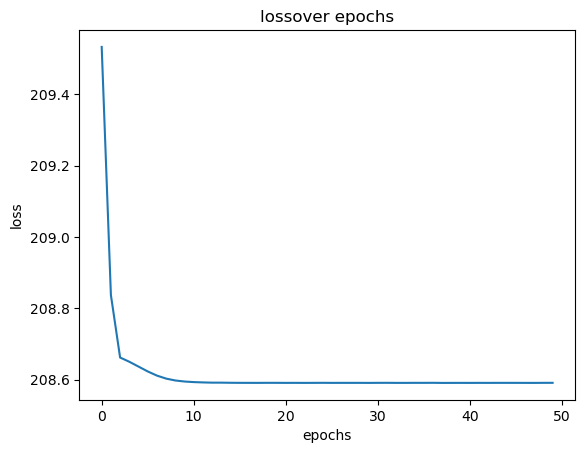

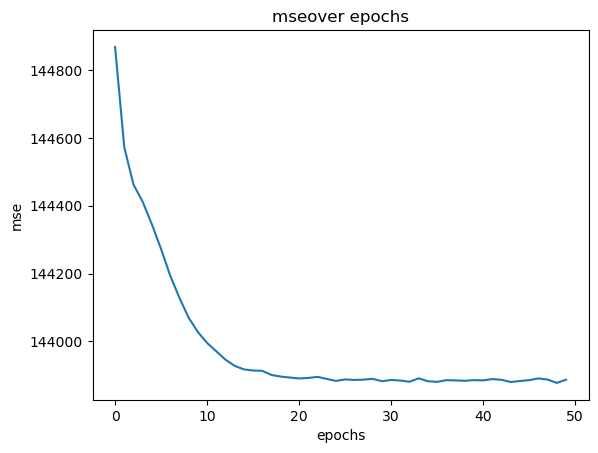

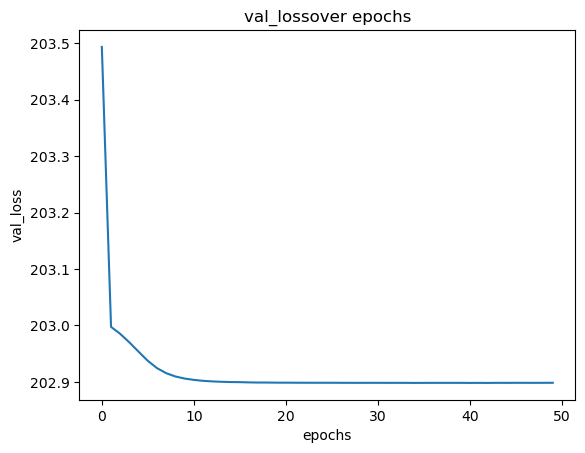

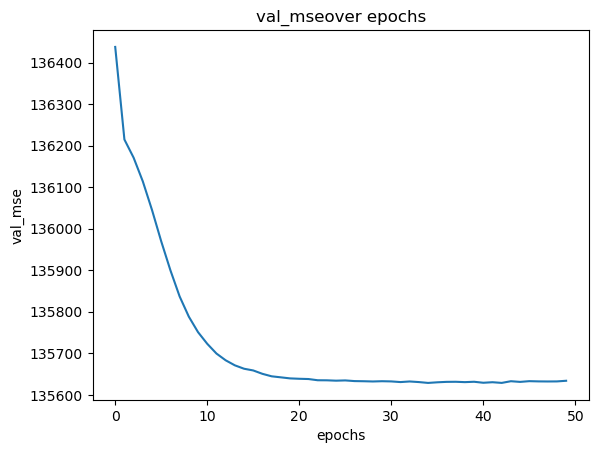

In [100]:
fit = history.history

for i in fit:
    plt.plot(fit[i])
    plt.title(i+'over epochs')
    plt.ylabel(i)
    plt.xlabel('epochs')
    plt.show()

In [102]:
scores = model.evaluate(xtest, ytest)
mae = scores[0]
mse = scores[1]
print('Mean absolute error:', mae)

205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 203.0106 - mse: 139923.2812  
Mean absolute error: 197.01043701171875


In [104]:
mean_absolute_error(ytest, model.predict(xtest))

205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step   


197.0104452560392